In [1]:
%matplotlib inline
from edward.util import Progbar
import tensorflow as tf
from utils import generator_xy
import keras
import edward as ed
import numpy as np
from observations import mnist
import matplotlib.pyplot as plt
from edward.models import Normal, Bernoulli, Categorical
import pickle
import seaborn as sns
plt.style.use('ggplot')

Using TensorFlow backend.


In [2]:
sess = tf.InteractiveSession()
ed.set_seed(100)
M = 12000
(x_train, y_train), (x_test, y_test) = mnist('./data')
y_train = tf.cast(y_train, tf.int32).eval()
y_test = tf.cast(y_test, tf.int32).eval()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train_generator = generator_xy([x_train,y_train], M)

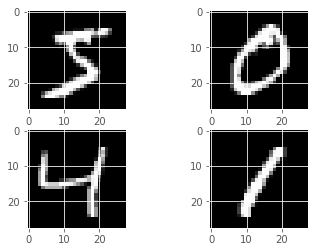

In [3]:
f, axes = plt.subplots(2, 2)
for ax, i in zip(axes.flat[0:], range(4)):
    ax.imshow(x_train[i,:].reshape(28,28),cmap = 'gray')
plt.show()

In [4]:

def auto_encoder(x, W_encode, W_decode, b_endoce, b_decode):
    h = tf.nn.relu(tf.matmul(x,W_encode) + b_encode)
    h = tf.nn.sigmoid(tf.matmul(h,W_decode) + b_decode)
    return h

def mlp(x, W_1, W_2, b_1, b_2):
    h = tf.nn.relu(tf.matmul(x, W_1) + b_1)
    h = tf.nn.softmax(tf.matmul(h, W_2) + b_2)
    return h

def encoder(x, W_encode, b_encode):
    h = tf.nn.relu(tf.matmul(x,W_encode) + b_encode)
    return h

def accuracy(y_true, y_pred):
    correct = 0
    for i in range(len(y_true)):
        if y_true[i] == y_pred[i]:
            correct += 1
        else:
            pass
    return correct/len(y_true)* 1.

In [24]:
W_encode = Normal(loc = tf.zeros([28*28, 256]), scale = 0.01 * tf.ones([28*28, 256]))
W_decode = Normal(loc = tf.zeros([256, 28*28]), scale = 0.01 * tf.ones([256,28*28]))
b_encode = Normal(loc = tf.zeros(256), scale = 0.01 * tf.ones(256))
b_decode = Normal(loc = tf.zeros(28*28), scale = 0.01 * tf.ones(28*28))
W_clf_1  = Normal(loc = tf.zeros([256, 100]), scale = tf.ones([256, 100]))
b_clf_1  = Normal(loc = tf.zeros(100), scale = tf.ones(100)) 
W_clf_2  = Normal(loc = tf.zeros([100,10]), scale = tf.ones([100, 10]))
b_clf_2  = Normal(loc = tf.zeros(10), scale = tf.ones(10))


x = tf.placeholder(tf.float32, [None, 28 * 28])

x_reconstruct = Normal(loc=auto_encoder(x, W_encode, W_decode, b_encode, b_decode),
                      scale = 0.1 *tf.ones([28*28]))
y = Categorical(logits = mlp(encoder(x, W_encode, b_encode) 
                             , W_clf_1, W_clf_2, b_clf_1, b_clf_2))

In [6]:
qW_encode = Normal(loc = tf.Variable(tf.random_normal([28*28,256])),
                  scale = tf.nn.softplus(tf.Variable(tf.random_normal([28*28,256]))))
qW_decode = Normal(loc = tf.Variable(tf.random_normal([256,28*28])),
                  scale = tf.nn.softplus(tf.Variable(tf.random_normal([256,28*28]))))
qb_encode = Normal(loc = tf.Variable(tf.random_normal([256])),
                  scale = tf.nn.softplus(tf.Variable(tf.random_normal([256]))))
qb_decode = Normal(loc = tf.Variable(tf.random_normal([28*28])),
                   scale = tf.nn.softplus(tf.Variable(tf.random_normal([28*28]))))

qW_clf_1 = Normal(loc = tf.Variable(tf.random_normal([256,100])),
                  scale = tf.nn.softplus(tf.Variable(tf.random_normal([256,100]))))
qW_clf_2 = Normal(loc = tf.Variable(tf.random_normal([100,10])),
                  scale = tf.nn.softplus(tf.Variable(tf.random_normal([100,10]))))
qb_clf_1 = Normal(loc = tf.Variable(tf.random_normal([100])),
                  scale = tf.nn.softplus(tf.Variable(tf.random_normal([100]))))
qb_clf_2 = Normal(loc = tf.Variable(tf.random_normal([10])),
                   scale = tf.nn.softplus(tf.Variable(tf.random_normal([10]))))



In [7]:
reconstruct = tf.stack([auto_encoder(x,qW_encode.sample(), 
                                   qW_decode.sample(), qb_encode.sample(), 
                                   qb_decode.sample()) 
                          for _ in range(4)])
tf.global_variables_initializer().run()
out = sess.run(reconstruct, feed_dict = {x: x_train})


(4, 60000, 784)


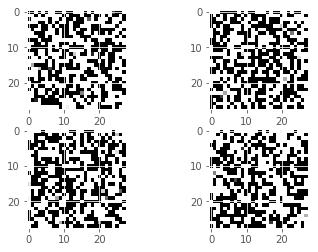

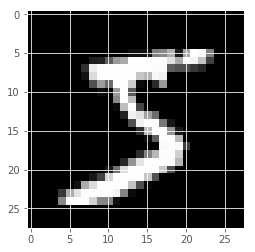

In [8]:
print(out.shape)
f, axes = plt.subplots(2, 2)
for ax, i in zip(axes.flat[0:], range(4)):
    ax.imshow(out[i,0,:].reshape(28,28),cmap = 'gray')
plt.show()
plt.imshow(x_train[0,:].reshape(28, 28), cmap = 'gray')
plt.show()

In [9]:
inference = ed.KLqp({W_encode:qW_encode, b_encode:qb_encode,
                    W_decode:qW_decode, b_decode:qb_decode, 
                    W_clf_1: qW_clf_1, W_clf_2: qW_clf_2, 
                    b_clf_1: qb_clf_1, b_clf_2: qb_clf_2}, 
                    data = {x: x_train, x_reconstruct: x_train, 
                           y: y_train})
inference.initialize(n_iter = 1000, n_samples = 5)
tf.global_variables_initializer().run()


In [10]:
n_epoch = 40
n_iter_per_epoch = x_train.shape[0] // M
log_loss = []
for epoch in range(1, n_epoch + 1):
  print("Epoch: {0}".format(epoch))
  avg_loss = 0.0

  pbar = Progbar(n_iter_per_epoch, verbose = 0)
  for t in range(1, n_iter_per_epoch + 1):
    pbar.update(t)
    x_batch, y_batch = next(x_train_generator)
    info_dict = inference.update(feed_dict={x: x_batch, x_reconstruct: x_batch, 
                                           y: y_batch})
    avg_loss += info_dict['loss']
  avg_loss = avg_loss / n_iter_per_epoch
  avg_loss = avg_loss / M
  log_loss.append(avg_loss)
  print("-log p(x) <= {:0.3f}".format(avg_loss))
    

Epoch: 1
-log p(x) <= 51723.025
Epoch: 2
-log p(x) <= 27334.057
Epoch: 3
-log p(x) <= 26195.166
Epoch: 4
-log p(x) <= 25237.290
Epoch: 5
-log p(x) <= 24276.377
Epoch: 6
-log p(x) <= 23353.383
Epoch: 7
-log p(x) <= 22349.266
Epoch: 8
-log p(x) <= 21490.005
Epoch: 9
-log p(x) <= 20679.794
Epoch: 10
-log p(x) <= 19897.666
Epoch: 11
-log p(x) <= 19259.873
Epoch: 12
-log p(x) <= 18624.013
Epoch: 13
-log p(x) <= 18032.330
Epoch: 14
-log p(x) <= 17445.441
Epoch: 15
-log p(x) <= 16821.618
Epoch: 16
-log p(x) <= 16236.893
Epoch: 17
-log p(x) <= 15661.626
Epoch: 18
-log p(x) <= 15054.799
Epoch: 19
-log p(x) <= 14361.221
Epoch: 20
-log p(x) <= 13382.971
Epoch: 21
-log p(x) <= 12327.814
Epoch: 22
-log p(x) <= 11159.359
Epoch: 23
-log p(x) <= 9817.769
Epoch: 24
-log p(x) <= 8587.240
Epoch: 25
-log p(x) <= 7543.841
Epoch: 26
-log p(x) <= 6690.675
Epoch: 27
-log p(x) <= 6040.115
Epoch: 28
-log p(x) <= 5576.998
Epoch: 29
-log p(x) <= 5134.854
Epoch: 30
-log p(x) <= 4769.454
Epoch: 31
-log p(x) <= 4300

In [33]:
out = sess.run(reconstruct, feed_dict={x: x_test})
f, axes = plt.subplots(2, 2)
for ax, i in zip(axes.flat[0:], range(4)):
    ax.imshow(out[i,0,:].reshape(28,28),cmap = 'gray')
plt.show()
plt.imshow(x_test[0,:].reshape(28, 28), cmap = 'gray')
plt.show()

InvalidArgumentError: You must feed a value for placeholder tensor 'Placeholder' with dtype float and shape [?,784]
	 [[Node: Placeholder = Placeholder[dtype=DT_FLOAT, shape=[?,784], _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]

Caused by op 'Placeholder', defined at:
  File "/usr/lib/python3.5/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.5/dist-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/usr/local/lib/python3.5/dist-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/usr/local/lib/python3.5/dist-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 2728, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 2850, in run_ast_nodes
    if self.run_code(code, result):
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-5-ef45b3697e84>", line 11, in <module>
    x = tf.placeholder(tf.float32, [None, 28 * 28])
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/array_ops.py", line 1599, in placeholder
    return gen_array_ops._placeholder(dtype=dtype, shape=shape, name=name)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/gen_array_ops.py", line 3091, in _placeholder
    "Placeholder", dtype=dtype, shape=shape, name=name)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/ops.py", line 2956, in create_op
    op_def=op_def)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/ops.py", line 1470, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

InvalidArgumentError (see above for traceback): You must feed a value for placeholder tensor 'Placeholder' with dtype float and shape [?,784]
	 [[Node: Placeholder = Placeholder[dtype=DT_FLOAT, shape=[?,784], _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]


In [12]:
encode_weights = qW_encode.sample()
encode_bias = qb_encode.sample()
train_encoded = tf.matmul(x_train, encode_weights) + encode_bias
test_encoded = tf.matmul(x_test, encode_weights) + encode_bias
print(train_encoded.eval().shape)
print(test_encoded.eval().shape)
with open('./data/encoded_train_BAE.pkl','wb') as f:
    pickle.dump(train_encoded.eval(),f)
with open('./data/encoded_test_BAE.pkl','wb') as f:
    pickle.dump(test_encoded.eval(),f)

(60000, 256)
(10000, 256)


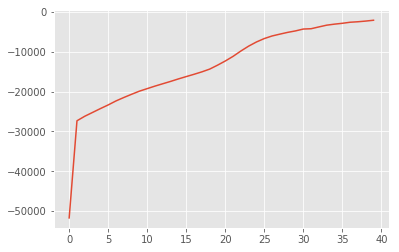

In [13]:
log_loss_temp = np.multiply(log_loss, -1)
plt.plot(range(40), log_loss_temp)
plt.show()

In [31]:
y_pred_train = mlp(train_encoded, qW_clf_1.sample(),qW_clf_2.sample(),qb_clf_1.sample(), qb_clf_2.sample())
y_pred_train = [np.argmax(i) for i in y_pred_train.eval()]

y_pred_test = mlp(test_encoded, qW_clf_1.sample(),qW_clf_2.sample(),qb_clf_1.sample(), qb_clf_2.sample())
y_pred_test = [np.argmax(i) for i in y_pred_test.eval()]

print(accuracy(y_train, y_pred_train))
print(accuracy(y_test, y_pred_test))

0.4666
0.5039


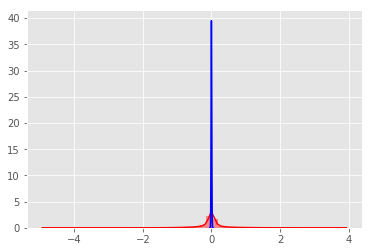

In [26]:
pos_encode = qW_encode.sample().eval()
pri_encode = W_encode.sample().eval()

sns.distplot(np.ndarray.flatten(pos_encode), color = 'red')
sns.distplot(np.ndarray.flatten(pri_encode), color = 'blue')
plt.show()